<a href="https://colab.research.google.com/github/kyochanpy/Google_Smartphone_Decimeter_Challenge/blob/main/note_books/submission_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyproj > /dev/null

In [2]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [3]:
path = Path("/content/drive/MyDrive/GSDC")
train_base = pd.read_csv(path / "baseline_locations_train.csv")
test_base = pd.read_csv(path / "baseline_locations_test.csv")
sub = pd.read_csv(path / "sample_submission.csv")

In [4]:
def an2v(y_delta, z_delta, x_delta):
    # yaw: z
    Rz_Matrix = np.matrix([
    [math.cos(z_delta), -math.sin(z_delta), 0],
    [math.sin(z_delta), math.cos(z_delta), 0],
    [0, 0, 1]
    ])
    
    # pitch: y
    Ry_Matrix = np.matrix([
    [math.cos(y_delta), 0, math.sin(y_delta)],
    [0, 1, 0],
    [-math.sin(y_delta), 0, math.cos(y_delta)]
    ])
    
    # roll: x
    Rx_Matrix = np.matrix([
    [1, 0, 0],
    [0, math.cos(x_delta), -math.sin(x_delta)],
    [0, math.sin(x_delta), math.cos(x_delta)]
    ])

    R = Rz_Matrix * Ry_Matrix * Rx_Matrix

    theta = math.acos(((R[0, 0] + R[1, 1] + R[2, 2]) - 1) / 2)
    multi = 1 / (2 * math.sin(theta))

    rx = multi * (R[2, 1] - R[1, 2]) * theta
    ry = multi * (R[0, 2] - R[2, 0]) * theta
    rz = multi * (R[1, 0] - R[0, 1]) * theta

    return rx, ry, rz

In [5]:
def v2a(rotation_v):
    # Rotation Vector -> Rotation Matrix
    R = Rodrigues(rotation_v)[0]

    sq = sqrt(R[2,1] ** 2 +  R[2,2] ** 2)

    if  not (sq < 1e-6) :
        x_delta = atan2(R[2,1] , R[2,2])
        y_delta = atan2(-R[2,0], sq)
        z_delta = atan2(R[1,0], R[0,0])
    else :
        x_delta = atan2(-R[1,2], R[1,1])
        y_delta = atan2(-R[2,0], sq)
        z_delta = 0

    return y_delta, z_delta, x_delta

In [6]:
def gnss_log_to_dataframes(path):
    '''Load GNSS Log'''
    print('Loading ' + path, flush = True)
    gnss_section_names = {'Raw', 'UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg', 'OrientationDe', 'Orientatio'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [7]:
def UTC2GpsEpoch(df):
    dt_offset = pd.to_datetime('1980-01-06 00:00:00') 
    dt_offset_in_ms = int(dt_offset.value / 1e6)
    df['millisSinceGpsEpoch'] = df['utcTimeMillis'] - dt_offset_in_ms + 18000
    return df

In [8]:
def prepare_imu_data(path, dataset_name, cname, pname, bl_df):
    # load GNSS log
    gnss_df = gnss_log_to_dataframes(str(path / dataset_name / cname / pname / f'{pname}_GnssLog.txt'))
    print('sub-dataset shape：')
    print('Raw:', gnss_df['Raw'].shape)
    print('Status:', gnss_df['Status'].shape)
    print('UncalAccel:', gnss_df['UncalAccel'].shape)
    print('UncalGyro:', gnss_df['UncalGyro'].shape)
    print('UncalMag:', gnss_df['UncalMag'].shape)
    print('OrientationDeg:', gnss_df['OrientationDeg'].shape)
    print('OrientationDe:', gnss_df['OrientationDe'].shape)
    print('Orientatio:', gnss_df['Orientatio'].shape)
    print('Fix:', gnss_df['Fix'].shape)

    # merge sub-datasets
    # accel + gyro
    imu_df = pd.merge_asof(gnss_df['UncalAccel'].sort_values('utcTimeMillis'),
                           gnss_df['UncalGyro'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # (accel + gyro) + mag
    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['UncalMag'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # ((accel + gyro) + mag) + OrientationDeg
    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['OrientationDeg'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
   
    # UTC->GpsEpoch
    imu_df = UTC2GpsEpoch(imu_df)

    # print IMU time
    dt_offset = pd.to_datetime('1980-01-06 00:00:00')
    dt_offset_in_ms = int(dt_offset.value / 1e6)
    tmp_datetime = pd.to_datetime(imu_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
    print(f"imu_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")


    if dataset_name == 'train':
        # read GT dataset
        gt_path = path / dataset_name / cname / pname / 'ground_truth.csv'
        gt_df = pd.read_csv(gt_path, usecols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg'])

        # print GT time
        tmp_datetime = pd.to_datetime(gt_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
        print(f"gt_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")

        # merge GT dataset
        imu_df = pd.merge_asof(gt_df.sort_values('millisSinceGpsEpoch'),
                               imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                               on = 'millisSinceGpsEpoch',
                               direction='nearest')
    elif dataset_name == 'test':
        # merge smaple_df
        imu_df = pd.merge_asof(sub.sort_values('millisSinceGpsEpoch'),
                           imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                           on = 'millisSinceGpsEpoch',
                           direction='nearest')

    # OrientationDeg -> Rotation Vector
    rxs = []
    rys = []
    rzs = []
    for i in range(len(imu_df)):
        y_delta = imu_df['rollDeg'].iloc[i]
        z_delta = imu_df['yawDeg'].iloc[i]
        x_delta = imu_df['pitchDeg'].iloc[i]
        rx, ry, rz = an2v(y_delta, z_delta, x_delta)
        rxs.append(rx)
        rys.append(ry)
        rzs.append(rz)

    imu_df['ahrsX'] = rxs
    imu_df['ahrsY'] = rys
    imu_df['ahrsZ'] = rzs

    # calibrate sensors' reading
    for axis in ['X', 'Y', 'Z']:
        imu_df['Accel{}Mps2'.format(axis)] = imu_df['UncalAccel{}Mps2'.format(axis)] - imu_df['Bias{}Mps2'.format(axis)]
        imu_df['Gyro{}RadPerSec'.format(axis)] = imu_df['UncalGyro{}RadPerSec'.format(axis)] - imu_df['Drift{}RadPerSec'.format(axis)]
        imu_df['Mag{}MicroT'.format(axis)] = imu_df['UncalMag{}MicroT'.format(axis)] - imu_df['Bias{}MicroT'.format(axis)]

        # clearn bias features
        imu_df.drop(['Bias{}Mps2'.format(axis), 'Drift{}RadPerSec'.format(axis), 'Bias{}MicroT'.format(axis)], axis = 1, inplace = True) 

    if dataset_name == 'train':
        # merge Baseline dataset：imu_df + bl_df = (GT + IMU) + Baseline
        df_all = pd.merge(imu_df.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'}),
                      bl_df.drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_bl','lngDeg':'lngDeg_bl'}),
                      on = ['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
    elif dataset_name == 'test':
        df_all = pd.merge(imu_df,
              bl_df[(bl_df['collectionName']==cname) & (bl_df['phoneName']==pname)].drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_bl','lngDeg':'lngDeg_bl'}),
              on = ['millisSinceGpsEpoch'])
        df_all.drop(['phone'], axis=1, inplace=True)
        
    return df_all

In [9]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)
def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt

In [10]:
def get_xyz(df_all, dataset_name):
    # baseline: lat/lngDeg -> x/y/z
    df_all['Xbl'], df_all['Ybl'], df_all['Zbl'] = zip(*df_all.apply(lambda x: WGS84_to_ECEF(x.latDeg_bl, x.lngDeg_bl, x.heightAboveWgs84EllipsoidM), axis=1))
    
    if dataset_name == 'train':
        # gt: lat/lngDeg -> x/y/z
        df_all['Xgt'], df_all['Ygt'], df_all['Zgt'] = zip(*df_all.apply(lambda x: WGS84_to_ECEF(x.latDeg_gt, x.lngDeg_gt, x.heightAboveWgs84EllipsoidM), axis=1))
        # copy lat/lngDeg
        lat_lng_df = df_all[['latDeg_gt','lngDeg_gt', 'latDeg_bl', 'lngDeg_bl']]
        df_all.drop(['latDeg_gt','lngDeg_gt', 'latDeg_bl', 'lngDeg_bl'], axis = 1, inplace = True)
    elif dataset_name == 'test':
        # copy lat/lngDeg
        lat_lng_df = df_all[['latDeg_bl', 'lngDeg_bl']]
        df_all.drop(['latDeg_bl', 'lngDeg_bl', 'latDeg','lngDeg',], axis = 1, inplace = True)     
        
    return lat_lng_df, df_all

In [11]:
def prepare_df_train(df_all_train, window_size):
    '''prepare training dataset with all aixses'''
    tgt_df = df_all_train.copy()
    total_len = len(tgt_df) 
    moving_times = total_len - window_size 
    
    tgt_df.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(tgt_df) if f not in ['Xgt', 'Ygt', 'Zgt']]

    # Historical Feature names
    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # Window Sliding
    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7

    # Add historical data 
    df_train = pd.DataFrame()
    features = []
    xs = []
    ys = []
    zs = []

    for start_idx in range(moving_times):
        feature_list = list()
        x_list = list()
        y_list = list()
        z_list = list()

        for window_idx in range(window_size):
            feature_list.extend(tgt_df[feature_cols].iloc[start_idx + window_idx,:].to_list())
        x_list.append(tgt_df['Xgt'].iloc[start_idx + window_size])
        y_list.append(tgt_df['Ygt'].iloc[start_idx + window_size])
        z_list.append(tgt_df['Zgt'].iloc[start_idx + window_size])

        features.append(feature_list)
        xs.extend(x_list)
        ys.extend(y_list)
        zs.extend(z_list)

    df_train = pd.DataFrame(features, columns = hist_feats)
    df_train['Xgt'] = xs
    df_train['Ygt'] = ys
    df_train['Zgt'] = zs
    
    # clean single-value feature: collectionName_[1-5]\phoneName_[1-5]
    tmp_feats = []
    for fn in list(df_train):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_train = df_train[tmp_feats]

    # clean time feature
    tmp_drop_feats = []
    for f in list(df_train):
        if (f.startswith('millisSinceGpsEpoch') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True):
            tmp_drop_feats.append(f)
    df_train.drop(tmp_drop_feats, axis = 1, inplace = True)
    
    return df_train

In [12]:
def prepare_df_test(df_all_test, window_size):
    '''prepare testing dataset with all aixses'''
    tgt_df = df_all_test.copy()
    total_len = len(tgt_df) 
    moving_times = total_len - window_size 
    
    tgt_df.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(tgt_df) if f not in ['Xgt', 'Ygt', 'Zgt']] 
    
    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7
    df_test = pd.DataFrame()
    features = []

    for start_idx in range(moving_times):
        feature_list = list()

        for window_idx in range(window_size):
            feature_list.extend(tgt_df[feature_cols].iloc[start_idx + window_idx,:].to_list())
        features.append(feature_list)

    df_test = pd.DataFrame(features, columns = hist_feats)

    tmp_feats = []
    for fn in list(df_test):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_test = df_test[tmp_feats]

    tmp_drop_feats = []
    for f in list(df_test):
        if (f.startswith('millisSinceGpsEpoch') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True) or (f.startswith('elapsedRealtimeNanos') == True):
            tmp_drop_feats.append(f)
    df_test.drop(tmp_drop_feats, axis = 1, inplace = True)
    
    return df_test

In [13]:
def remove_other_axis_feats(df_all, tgt_axis):
    '''unrelated-aixs features and uncalibrated features'''
    # Clean unrelated-aixs features
    all_imu_feats = ['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2',
                     'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
                     'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
                     'ahrsX', 'ahrsY', 'ahrsZ',
                     'AccelXMps2', 'AccelYMps2', 'AccelZMps2',
                     'GyroXRadPerSec', 'GyroZRadPerSec', 'GyroYRadPerSec',
                     'MagXMicroT', 'MagYMicroT', 'MagZMicroT',
                     'yawZDeg', 'rollYDeg', 'pitchXDeg',
                     'Xbl', 'Ybl', 'Zbl']
    tgt_imu_feats = []
    for axis in ['X', 'Y', 'Z']:
        if axis != tgt_axis:
            for f in all_imu_feats:
                if f.find(axis) >= 0:
                    tgt_imu_feats.append(f)
            
    tmp_drop_feats = []
    for f in list(df_all):
        if f.split('_')[0] in tgt_imu_feats:
            tmp_drop_feats.append(f)

    tgt_df = df_all.drop(tmp_drop_feats, axis = 1)
    
    # Clean uncalibrated features
    uncal_feats = [f for f in list(tgt_df) if f.startswith('Uncal') == True]
    tgt_df = tgt_df.drop(uncal_feats, axis = 1)
    
    return tgt_df

In [14]:
def add_stat_feats(data, tgt_axis):
    for f in ['yawZDeg', 'rollYDeg', 'pitchXDeg']:
        if f.find(tgt_axis) >= 0:
            ori_feat = f
            break
            
    cont_feats = ['heightAboveWgs84EllipsoidM', 'ahrs{}'.format(tgt_axis),
           'Accel{}Mps2'.format(tgt_axis), 'Gyro{}RadPerSec'.format(tgt_axis), 'Mag{}MicroT'.format(tgt_axis),
            '{}bl'.format(tgt_axis)] + [ori_feat]
    
    for f in cont_feats:
        data[f + '_' + str(window_size) + '_mean'] = data[[f + f'_{i}' for i in range(1,window_size)]].mean(axis=1)
        data[f + '_' + str(window_size) + '_std'] = data[[f + f'_{i}' for i in range(1,window_size)]].std(axis=1)
        data[f + '_' + str(window_size) + '_max'] = data[[f + f'_{i}' for i in range(1,window_size)]].max(axis=1)
        data[f + '_' + str(window_size) + '_min'] = data[[f + f'_{i}' for i in range(1,window_size)]].min(axis=1)
        data[f + '_' + str(window_size) + '_median'] = data[[f + f'_{i}' for i in range(1,window_size)]].median(axis=1)
    return data

In [17]:
# LightGBM
params = {
    'metric':'mse',
    'objective':'regression',
    'seed':2021,
    'boosting_type':'gbdt',
    'early_stopping_rounds':10,
    'subsample':0.7,
    'feature_fraction':0.7,
    'bagging_fraction': 0.7,
    'reg_lambda': 10
}
window_size = 30
verbose_flag = True
folds = 5

In [18]:
# Example: I use SJC's dataset for training 
tgt_cns = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2']
cn2pn_df = train_base[['collectionName', 'phoneName']].drop_duplicates()

df_trains = []
lat_lng_df_trains = []
for tgt_cn in tqdm(tgt_cns):
    pns = list(cn2pn_df[cn2pn_df['collectionName'] == tgt_cn]['phoneName'].values)
    for tgt_pn in pns:
        print('Prepare Training Dataset：', tgt_cn + '_' + tgt_pn)  
        df_all_train = prepare_imu_data(path, 'train', tgt_cn, tgt_pn, train_base)
        display(df_all_train.head(1))
        lat_lng_df_train, df_all_train = get_xyz(df_all_train, 'train')
        df_train = prepare_df_train(df_all_train,  window_size) # 所有轴的数据
        df_trains.append(df_train)
        lat_lng_df_trains.append(lat_lng_df_train)
        print('_'*20)
        
df_train = pd.concat(df_trains, axis = 0)
lat_lng_df_train = pd.concat(lat_lng_df_trains, axis = 0)
print('Final Dataset shape：', df_train.shape)


  0%|          | 0/3 [00:00<?, ?it/s]

Prepare Training Dataset： 2021-04-22-US-SJC-1_Pixel4
Loading /content/drive/MyDrive/GSDC/train/2021-04-22-US-SJC-1/Pixel4/Pixel4_GnssLog.txt
sub-dataset shape：
Raw: (69759, 36)
Status: (105134, 13)
UncalAccel: (300038, 8)
UncalGyro: (300038, 8)
UncalMag: (289948, 8)
OrientationDeg: (180408, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-22 21:02:55.866000 - 2021-04-22 21:51:07.442000
gt_df time scope: 2021-04-22 21:02:55.446000 - 2021-04-22 21:51:06.446000


,collectionName,phoneName,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,utcTimeMillis,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,yawDeg,rollDeg,pitchDeg,ahrsX,ahrsY,ahrsZ,AccelXMps2,GyroXRadPerSec,MagXMicroT,AccelYMps2,GyroYRadPerSec,MagYMicroT,AccelZMps2,GyroZRadPerSec,MagZMicroT,latDeg_bl,lngDeg_bl,heightAboveWgs84EllipsoidM
0,2021-04-22-US-SJC-1,Pixel4,1303160575446,37.334581,-121.899447,1619125357866,-1.211366,9.678967,-0.855434,-0.011301,-0.003054,-0.005498,32.08125,-70.44375,-74.362495,106,128,-81,1.28383,2.061713,-1.186817,-1.211366,-0.01122,26.446653,9.678967,-0.002877,-52.221582,-0.855434,-0.004449,-36.499535,37.334582,-121.899408,-10.66


____________________
Prepare Training Dataset： 2021-04-22-US-SJC-1_SamsungS20Ultra
Loading /content/drive/MyDrive/GSDC/train/2021-04-22-US-SJC-1/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
sub-dataset shape：
Raw: (103693, 36)
Status: (39416, 13)
UncalAccel: (282622, 8)
UncalGyro: (282622, 8)
UncalMag: (282622, 8)
OrientationDeg: (282623, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-22 21:02:57.127000 - 2021-04-22 21:50:03.236000
gt_df time scope: 2021-04-22 21:02:57 - 2021-04-22 21:50:02


,collectionName,phoneName,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,utcTimeMillis,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,yawDeg,rollDeg,pitchDeg,ahrsX,ahrsY,ahrsZ,AccelXMps2,GyroXRadPerSec,MagXMicroT,AccelYMps2,GyroYRadPerSec,MagYMicroT,AccelZMps2,GyroZRadPerSec,MagZMicroT,latDeg_bl,lngDeg_bl,heightAboveWgs84EllipsoidM
0,2021-04-22-US-SJC-1,SamsungS20Ultra,1303160577000,37.334582,-121.899444,1619125359127,-1.271321,9.725547,-1.326388,-0.02138,0.012217,0.009163,3.24,-68.58,-15.54,54,136.0,-79.0,-0.14802,-0.983886,0.333922,-1.271321,-0.01749,27.179999,9.725547,-0.003202,-48.720001,-1.323994,-0.002215,5.1,37.334587,-121.899431,-4.1



 33%|███▎      | 1/3 [04:12<08:24, 252.23s/it]

____________________
Prepare Training Dataset： 2021-04-28-US-SJC-1_Pixel4
Loading /content/drive/MyDrive/GSDC/train/2021-04-28-US-SJC-1/Pixel4/Pixel4_GnssLog.txt
sub-dataset shape：
Raw: (58202, 36)
Status: (82169, 13)
UncalAccel: (209435, 8)
UncalGyro: (209435, 8)
UncalMag: (201994, 8)
OrientationDeg: (126160, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-28 19:59:34.375000 - 2021-04-28 20:33:12.928000
gt_df time scope: 2021-04-28 19:59:34.438000 - 2021-04-28 20:33:12.438000


,collectionName,phoneName,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,utcTimeMillis,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,yawDeg,rollDeg,pitchDeg,ahrsX,ahrsY,ahrsZ,AccelXMps2,GyroXRadPerSec,MagXMicroT,AccelYMps2,GyroYRadPerSec,MagYMicroT,AccelZMps2,GyroZRadPerSec,MagZMicroT,latDeg_bl,lngDeg_bl,heightAboveWgs84EllipsoidM
0,2021-04-28-US-SJC-1,Pixel4,1303675174438,37.334153,-121.90026,1619639956442,-0.735793,9.826126,-0.872184,0.011606,0.003818,-0.000305,22.89375,-60.0,-74.90625,97,137,-83,0.858679,-1.418035,1.383556,-0.735793,0.011997,21.556401,9.826126,0.003989,-45.201324,-0.872184,0.001114,-15.00326,37.334151,-121.900248,-6.66


____________________
Prepare Training Dataset： 2021-04-28-US-SJC-1_SamsungS20Ultra
Loading /content/drive/MyDrive/GSDC/train/2021-04-28-US-SJC-1/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
sub-dataset shape：
Raw: (83566, 36)
Status: (44529, 13)
UncalAccel: (208424, 8)
UncalGyro: (208424, 8)
UncalMag: (208424, 8)
OrientationDeg: (208425, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-28 19:59:33.164000 - 2021-04-28 20:34:16.989000
gt_df time scope: 2021-04-28 19:59:34 - 2021-04-28 20:34:16


,collectionName,phoneName,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,utcTimeMillis,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,yawDeg,rollDeg,pitchDeg,ahrsX,ahrsY,ahrsZ,AccelXMps2,GyroXRadPerSec,MagXMicroT,AccelYMps2,GyroYRadPerSec,MagYMicroT,AccelZMps2,GyroZRadPerSec,MagZMicroT,latDeg_bl,lngDeg_bl,heightAboveWgs84EllipsoidM
0,2021-04-28-US-SJC-1,SamsungS20Ultra,1303675174000,37.334152,-121.900258,1619639956004,-0.878672,9.589077,-1.252167,0.009163,0.012217,0.014661,-21.359999,-48.239998,5.34,180,-180,0,2.233208,1.11929,-1.11929,-0.878672,0.006486,3.240001,9.589077,0.002229,-115.559998,-1.249773,0.001896,19.74,37.334131,-121.900276,11.16



 67%|██████▋   | 2/3 [07:05<03:48, 228.43s/it]

____________________
Prepare Training Dataset： 2021-04-29-US-SJC-2_Pixel4
Loading /content/drive/MyDrive/GSDC/train/2021-04-29-US-SJC-2/Pixel4/Pixel4_GnssLog.txt
sub-dataset shape：
Raw: (75693, 36)
Status: (114063, 13)
UncalAccel: (241840, 8)
UncalGyro: (241841, 8)
UncalMag: (232787, 8)
OrientationDeg: (145695, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-29 18:59:06.468000 - 2021-04-29 19:37:57.577000
gt_df time scope: 2021-04-29 18:59:06.435000 - 2021-04-29 19:37:56.435000


,collectionName,phoneName,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,utcTimeMillis,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,yawDeg,rollDeg,pitchDeg,ahrsX,ahrsY,ahrsZ,AccelXMps2,GyroXRadPerSec,MagXMicroT,AccelYMps2,GyroYRadPerSec,MagYMicroT,AccelZMps2,GyroZRadPerSec,MagZMicroT,latDeg_bl,lngDeg_bl,heightAboveWgs84EllipsoidM
0,2021-04-29-US-SJC-2,Pixel4,1303757946435,37.334479,-121.899598,1619722728468,-1.410569,9.847063,-1.429113,-0.014355,-0.001985,-0.001374,45.16875,-63.01875,-56.868748,54,130,-79,-0.043558,-1.238227,0.240662,-1.410569,-0.013964,31.912175,9.847063,-0.001688,-45.663628,-1.429113,0.00039,-0.728451,37.334493,-121.899602,-9.15


____________________
Prepare Training Dataset： 2021-04-29-US-SJC-2_SamsungS20Ultra
Loading /content/drive/MyDrive/GSDC/train/2021-04-29-US-SJC-2/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
sub-dataset shape：
Raw: (98538, 36)
Status: (39835, 13)
UncalAccel: (237139, 8)
UncalGyro: (237139, 8)
UncalMag: (237139, 8)
OrientationDeg: (237140, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-29 18:59:08.892000 - 2021-04-29 19:38:39.990000
gt_df time scope: 2021-04-29 18:59:10 - 2021-04-29 19:38:39


,collectionName,phoneName,millisSinceGpsEpoch,latDeg_gt,lngDeg_gt,utcTimeMillis,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2,UncalGyroXRadPerSec,UncalGyroYRadPerSec,UncalGyroZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,yawDeg,rollDeg,pitchDeg,ahrsX,ahrsY,ahrsZ,AccelXMps2,GyroXRadPerSec,MagXMicroT,AccelYMps2,GyroYRadPerSec,MagYMicroT,AccelZMps2,GyroZRadPerSec,MagZMicroT,latDeg_bl,lngDeg_bl,heightAboveWgs84EllipsoidM
0,2021-04-29-US-SJC-2,SamsungS20Ultra,1303757950000,37.334481,-121.8996,1619722732003,-1.522712,9.589077,-1.608904,0.012828,0.008552,0.012217,-14.82,-63.84,10.38,180,-180,0,2.233208,1.11929,-1.11929,-1.522712,0.008547,-9.48,9.589077,-0.001324,-20.4,-1.606509,-0.00089,-6.6,37.33447,-121.899636,-4.86



100%|██████████| 3/3 [10:27<00:00, 209.25s/it]

____________________
Final Dataset shape： (14333, 843)


In [ ]:
test_base["collectionName"].unique()

array(['2020-05-15-US-MTV-1', '2020-05-28-US-MTV-1',
       '2020-05-28-US-MTV-2', '2020-06-04-US-MTV-2',
       '2020-06-10-US-MTV-1', '2020-06-10-US-MTV-2',
       '2020-08-03-US-MTV-2', '2020-08-13-US-MTV-1',
       '2021-03-16-US-MTV-2', '2021-03-16-US-RWC-2',
       '2021-03-25-US-PAO-1', '2021-04-02-US-SJC-1',
       '2021-04-08-US-MTV-1', '2021-04-21-US-MTV-1',
       '2021-04-22-US-SJC-2', '2021-04-26-US-SVL-2',
       '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2',
       '2021-04-29-US-SJC-3'], dtype=object)

In [19]:
tgt_cns_test = ['2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']
cn2pn_test_df = test_base[['collectionName', 'phoneName']].drop_duplicates()

df_tests = []
lat_lng_df_tests = []

for tgt_cn in tqdm(tgt_cns_test):
    pns = list(cn2pn_test_df[cn2pn_test_df['collectionName'] == tgt_cn]['phoneName'].values)
    for tgt_pn in pns:
        print('Prepare Training Dataset：', tgt_cn + '_' + tgt_pn)  
        df_all_test = prepare_imu_data(path, 'test', tgt_cn, tgt_pn, test_base)
        lat_lng_df_test, df_all_test = get_xyz(df_all_test, 'test')
        df_test = prepare_df_test(df_all_test,  window_size)
        df_tests.append(df_test)
        lat_lng_df_tests.append(lat_lng_df_test)

df_test = pd.concat(df_tests, axis = 0)
lat_lng_df_test = pd.concat(lat_lng_df_tests, axis = 0)
        
print('df_test:', df_test.shape)
print('df_test.columns:', df_test.columns)


  0%|          | 0/2 [00:00<?, ?it/s]

Prepare Training Dataset： 2021-04-22-US-SJC-2_SamsungS20Ultra
Loading /content/drive/MyDrive/GSDC/test/2021-04-22-US-SJC-2/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
sub-dataset shape：
Raw: (89737, 36)
Status: (40793, 13)
UncalAccel: (232389, 8)
UncalGyro: (232389, 8)
UncalMag: (232389, 8)
OrientationDeg: (232342, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-22 22:01:14.226000 - 2021-04-22 22:39:57.997000



 50%|█████     | 1/2 [01:55<01:55, 115.37s/it]

Prepare Training Dataset： 2021-04-29-US-SJC-3_Pixel4
Loading /content/drive/MyDrive/GSDC/test/2021-04-29-US-SJC-3/Pixel4/Pixel4_GnssLog.txt
sub-dataset shape：
Raw: (54937, 36)
Status: (83035, 13)
UncalAccel: (205625, 8)
UncalGyro: (205626, 8)
UncalMag: (197761, 8)
OrientationDeg: (123877, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-29 19:52:06.364000 - 2021-04-29 20:25:08.405000
Prepare Training Dataset： 2021-04-29-US-SJC-3_SamsungS20Ultra
Loading /content/drive/MyDrive/GSDC/test/2021-04-29-US-SJC-3/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
sub-dataset shape：
Raw: (78662, 36)
Status: (40565, 13)
UncalAccel: (206266, 8)
UncalGyro: (206266, 8)
UncalMag: (206266, 8)
OrientationDeg: (206266, 5)
OrientationDe: (0, 0)
Orientatio: (0, 0)
Fix: (0, 11)
imu_df time scope: 2021-04-29 19:52:07.506000 - 2021-04-29 20:26:29.991000



100%|██████████| 2/2 [05:09<00:00, 154.96s/it]

df_test: (6274, 840)
df_test.columns: Index(['UncalAccelXMps2_1', 'UncalAccelYMps2_1', 'UncalAccelZMps2_1',
       'UncalGyroXRadPerSec_1', 'UncalGyroYRadPerSec_1',
       'UncalGyroZRadPerSec_1', 'UncalMagXMicroT_1', 'UncalMagYMicroT_1',
       'UncalMagZMicroT_1', 'yawZDeg_1',
       ...
       'AccelYMps2_30', 'GyroYRadPerSec_30', 'MagYMicroT_30', 'AccelZMps2_30',
       'GyroZRadPerSec_30', 'MagZMicroT_30', 'heightAboveWgs84EllipsoidM_30',
       'Xbl_30', 'Ybl_30', 'Zbl_30'],
      dtype='object', length=840)


In [20]:
def training(df_train, df_test, tgt_axis, window_size):
    '''For the given axis target to train the model. Also, it has validation and prediciton.'''
    df_train = remove_other_axis_feats(df_train, tgt_axis)
    df_train = add_stat_feats(df_train, tgt_axis)
    df_test = remove_other_axis_feats(df_test, tgt_axis)
    df_test = add_stat_feats(df_test, tgt_axis)
    
    feature_names = [f for f in list(df_train) if f not in ['Xgt', 'Ygt', 'Zgt']]
    target = '{}gt'.format(tgt_axis)

    kfold = KFold(n_splits=folds, shuffle=True, random_state=params['seed'])

    pred_valid = np.zeros((len(df_train),)) 
    pred_test = np.zeros((len(df_test),)) 
    scores = []
    for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train, df_train[target])):
        X_train = df_train.iloc[trn_idx][feature_names]
        Y_train = df_train.iloc[trn_idx][target]
        X_val = df_train.iloc[val_idx][feature_names]
        Y_val = df_train.iloc[val_idx][target]

        model = lgb.LGBMRegressor(**params)
        lgb_model = model.fit(X_train, 
                              Y_train,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train, Y_train), (X_val, Y_val)],
                              verbose=0,
                              eval_metric=params['metric'],
                              early_stopping_rounds=params['early_stopping_rounds'])

        pred_valid[val_idx] = lgb_model.predict(X_val, num_iteration =  lgb_model.best_iteration_)
        pred_test += lgb_model.predict(df_test[feature_names], num_iteration =  lgb_model.best_iteration_)

        scores.append(lgb_model.best_score_['valid']['l2'])
    
    pred_test = pred_test /  kfold.n_splits
    
    if verbose_flag == True:
        print("Each Fold's MSE：{}, Average MSE：{:.4f}".format([np.round(v,2) for v in scores], np.mean(scores)))
        print("-"*60)
    return df_train, df_test, pred_valid, pred_test

In [21]:
df_train_x, df_test_x, pred_valid_x, pred_test_x = training(df_train, df_test, 'X', window_size)
df_train_y, df_test_y, pred_valid_y, pred_test_y = training(df_train, df_test, 'Y', window_size)
df_train_z, df_test_z, pred_valid_z, pred_test_z = training(df_train, df_test, 'Z', window_size)

Each Fold's MSE：[92.47, 119.83, 187.87, 101.97, 95.95], Average MSE：119.6173
------------------------------------------------------------
Each Fold's MSE：[191.07, 203.43, 377.38, 179.12, 148.73], Average MSE：219.9449
------------------------------------------------------------
Each Fold's MSE：[147.65, 160.86, 432.0, 161.76, 123.47], Average MSE：205.1483
------------------------------------------------------------


In [22]:
val_compare_df = pd.DataFrame({'Xgt':df_train_x['Xgt'].values, 'Xpred':pred_valid_x,
                               'Ygt':df_train_y['Ygt'].values, 'Ypred':pred_valid_y,
                                'Zgt':df_train_z['Zgt'].values, 'Zpred':pred_valid_z})

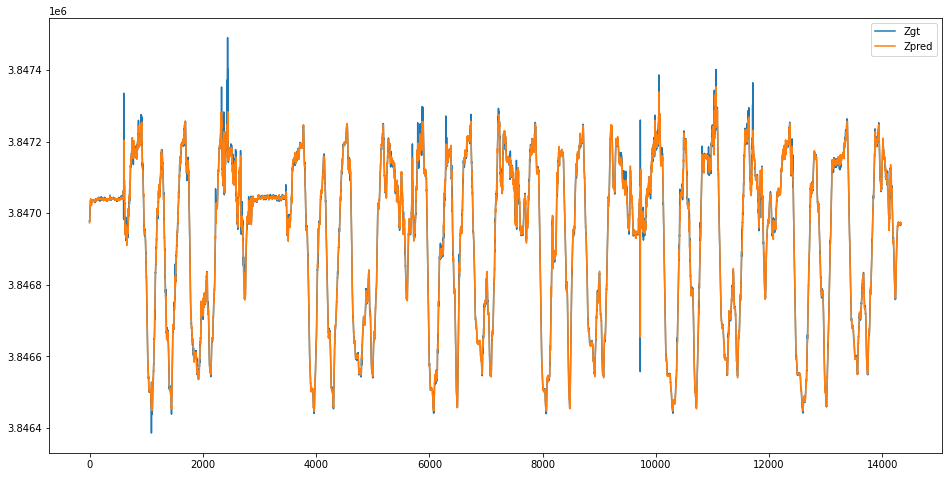

In [23]:
val_compare_df[['Zgt', 'Zpred']].plot(figsize=(16,8))

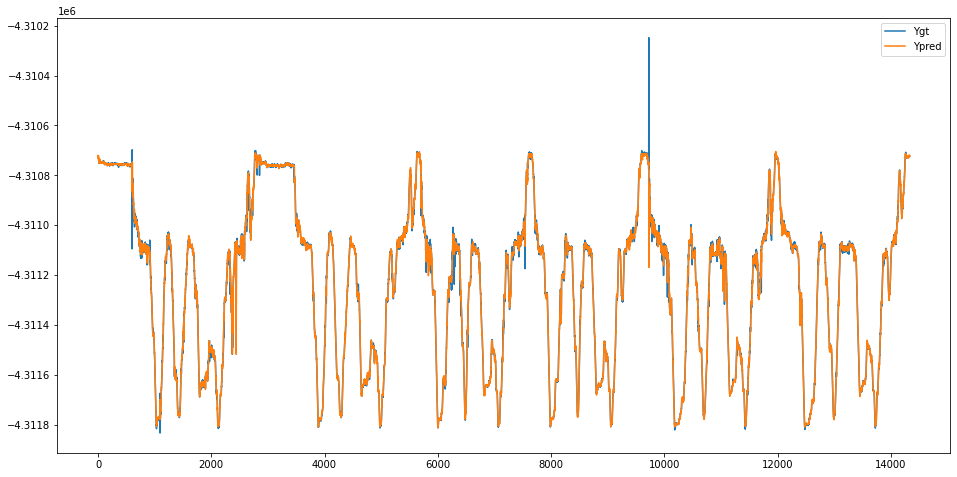

In [24]:
val_compare_df[['Ygt', 'Ypred']].plot(figsize=(16,8))


In [25]:
lng_gt, lat_gt, _ = ECEF_to_WGS84(val_compare_df['Xgt'].values,val_compare_df['Ygt'].values,val_compare_df['Zgt'].values)
lng_pred, lat_pred, _ = ECEF_to_WGS84(val_compare_df['Xpred'].values,val_compare_df['Ypred'].values,val_compare_df['Zpred'].values)
lng_test_pred, lat_test_pred, _ = ECEF_to_WGS84(pred_test_x, pred_test_y, pred_test_z)

    
val_compare_df['latDeg_gt'] = lat_gt
val_compare_df['lngDeg_gt'] = lng_gt
val_compare_df['latDeg_pred'] = lat_pred
val_compare_df['lngDeg_pred'] = lng_pred
test_pred_df = pd.DataFrame({'latDeg':lat_test_pred, 'lngDeg':lng_test_pred})

In [26]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(a**0.5)
    dist = 6_367_000 * c
    return dist

In [27]:
lat_lng_df_train['dist'] = calc_haversine(lat_lng_df_train.latDeg_gt, lat_lng_df_train.lngDeg_gt, 
                                lat_lng_df_train.latDeg_bl, lat_lng_df_train.lngDeg_bl)
print('dist_50:',np.percentile(lat_lng_df_train['dist'],50) )
print('dist_95:',np.percentile(lat_lng_df_train['dist'],95) )
print('avg_dist_50_95:',(np.percentile(lat_lng_df_train['dist'],50) + np.percentile(lat_lng_df_train['dist'],95))/2)
print('avg_dist:', lat_lng_df_train['dist'].mean())

dist_50: 6.129357526334204
dist_95: 33.83701581185293
avg_dist_50_95: 19.983186669093566
avg_dist: 10.5084494053175


In [28]:
val_compare_df['dist'] = calc_haversine(val_compare_df.latDeg_gt, val_compare_df.lngDeg_gt, 
                                val_compare_df.latDeg_pred, val_compare_df.lngDeg_pred)
# IMU预测vsGT（多collection）
print('dist_50:',np.percentile(val_compare_df['dist'],50) )
print('dist_95:',np.percentile(val_compare_df['dist'],95) )
print('avg_dist_50_95:',(np.percentile(val_compare_df['dist'],50) + np.percentile(val_compare_df['dist'],95))/2)
print('avg_dist:', val_compare_df['dist'].mean())

dist_50: 6.7433170042171975
dist_95: 19.431369398760978
avg_dist_50_95: 13.087343201489087
avg_dist: 8.34333618701736


In [41]:
test_base[test_base["phone"] == "2021-04-22-US-SJC-2_SamsungS20Ultra"]["latDeg"] = test_pred_df["latDeg"].iloc[0:2324]
test_base[test_base["phone"] == "2021-04-22-US-SJC-2_SamsungS20Ultra"]["lngDeg"] = test_pred_df["lngDeg"].iloc[0:2324]

In [42]:
test_base[test_base["collectionName"] == "2021-04-29-US-SJC-3"]["latDeg"] = test_pred_df["latDeg"].iloc[2325:6274]
test_base[test_base["collectionName"] == "2021-04-29-US-SJC-3"]["lngDeg"] = test_pred_df["lngDeg"].iloc[2325:6274]

In [43]:
test_base.to_csv("submission_27.csv", index=False)